# Introduction

In this notebook, I present the research and development of a multi-label neural network model for object detection(not localization, just present or not present). Specifically, the targeted devices for deployment are microcontrollers, so the model must be constrained.

My intention is to train a small model to detect whether a person, a car, or both are present in an image. Note that **the following scripts can be used for different classes and applications**. Please check the rest of the repository to learn more and see the deployment phase to different microcontrollers.



# Setup

First let's import all the libraries we will need and set some configuration parameters.

In [109]:
#Common imports
import numpy as np
import time, os, sys, zipfile
import pathlib
import urllib.request
import shutil
import random
from collections import defaultdict

# Tables
import pandas as pd

#Deep learning
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Reproducibility
random.seed(23)
np.random.seed(23)
tf.random.set_seed(23)

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Dataset utilities
from pycocotools.coco import COCO

As you can see in the last import, we will use the `pycocotools` library to build our data pipeline.

For reproducibility, here is some info of what I have installed:

In [5]:
# Record package versions for reproducibility
print("OS: {}".format(os.name))
print("Python version: {}".format(sys.version))
print("Numpy: {}".format(np.__version__))
print("Tensorflow: {}".format(tf.__version__))

OS: nt
Python version: 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 00:43:28) [MSC v.1916 64 bit (AMD64)]
Numpy: 1.19.1
Tensorflow: 2.3.0


Finally let's set up a couple of global variables

In [6]:
ROOT_PATH = "."
DATA_DIR = os.path.join(ROOT_PATH, "data")
coco_year = 2017

# Get the data

### Considerations

Unfortunately, the ImageNet dataset does not contain a class "person", so instead we can use the [COCO dataset](https://cocodataset.org/#home). On top of having the person class, the dataset name means "Common Objects in COntext" so, in theory, the images will be a better representation of the reality the model will be exposed to in the final application.

The visual wake word dataset would have been useful for this application if it could be extended to more than one foreground class, but it served as inspiration.

Finally, as we will see, retraining the final model(fine tuning) with captured images from the environment and device the model will be deployed on will help improve its performance.

### Why COCO?
The application proposed in the repository talks about detecting pedestrians and vehicles in crossroads, so using a more specialized dataset should be the right choice. On the other hand, this is meant to be a demo to test at home or show to your employer or stakeholders before proceeding with the final application. Therefore, the COCO dataset is a great choice due to its context rich images. It should be as easy as feeding the model a different dataset during the transfer learning phase to apply it to a similar task. At most, tuning some hyperparameters for fine-tuning.

### Execution
The COCO dataset is designed for a variety of deep learning applications, but classification is not one of them, so we will need to play with the COCO API to get the data in the format we want for **multi-label** classification.

The following class provides an easy interface to do just that, from downloading the original annotations and images, to the conversion to a `tf.dataset` or `torch.utils.data.DataLoader` object for an optimized data pipeline. The information and comments provided should be enough to understand its API, but do not forget to check the rest of the repository for the standalone script and more usage information.

In [122]:
class COCO_MLC():
    """
    COCO_C aims to convert the original COCO dataset into a classification problem. This approach
    makes the task easier and smaller models can be fit. Useful for constrained devices.
    
    Args:
        data_dir: Folder where all data will be downloaded
        year: COCO dataset year
    
    """
    def __init__(self, data_dir, year="2017"):
        self.data_dir = data_dir
        self.year = str(year)
        self.ANN_FOLDER = os.path.join(self.data_dir, "annotations")
        self.split_names = ["instances_train{}.json".format(self.year),
                            "instances_val{}.json".format(self.year)]
        self.coco_categories = []
        self.coco_objs = dict()
        self.datasets = []
        self.datasets_lens = []
        self.classes = []
        
        if not os.path.exists(self.data_dir):
            print("data_dir does not exist, creating directory now")
            os.makedirs(self.data_dir)
            
    def download_annotations(self, delete_zip=False):
        """
        Create annotations folder in data dir and download `year` COCO annotations.

        """
        ANN_ZIP_FILE_PATH = os.path.join(self.ANN_FOLDER, "annotations_train{}.zip".format(self.year))
        ANN_URL = r"http://images.cocodataset.org/annotations/annotations_trainval{}.zip".format(self.year)
        
        if not os.path.exists(self.ANN_FOLDER):
            print("Creating annotations folder: {}".format(self.ANN_FOLDER))
            os.makedirs(self.ANN_FOLDER)
        if not os.path.exists(ANN_ZIP_FILE_PATH):
            print("Downloading annotations...")
            with urllib.request.urlopen(ANN_URL) as resp, open(ANN_ZIP_FILE_PATH, 'wb') as out:
                shutil.copyfileobj(resp, out)
            print ("... done downloading.")
        
        print("Unzipping {}".format(ANN_ZIP_FILE_PATH))
        with zipfile.ZipFile(ANN_ZIP_FILE_PATH,"r") as zip_ref:
            for split in self.split_names:
                split_zip_path = os.path.join("annotations", split)
                split_zip_path = split_zip_path.replace("\\", "/") # Needed by zipfile
                zip_ref.extract(split_zip_path, self.data_dir)
        print ("... done unzipping")

        if delete_zip:
            print("Removing original zip file...")
            os.remove(ANN_ZIP_FILE_PATH)
        print("... done")
        
        # Let's create a list of categories for the user to check
        val_ann_file = os.path.join(self.ANN_FOLDER, self.split_names[1])
        coco_obj = COCO(val_ann_file)
        cats = coco_obj.loadCats(coco_obj.getCatIds())
        self.coco_categories = [cat['name'] for cat in cats]
        
        print("Download annotations done")
        
    def download_images(self, classes=[], threshold_areas=[], only_length=False, max_length=None,
                       add_negative_class=True, neg_classes=[]):
        """
        Download images from the desired classes and store them in different folders. For example, 
        after running `download_annotations` and then this function with "person" and "car" classes,
        we end up with a tree that looks as follows:

        -- data_dir
            |-- annotations
            |-- train
            |   |-- car
            |   `-- person
            `-- val
                |-- car
                `-- person

        
        Args:
            classes: classes from which to download images
            threshold_areas: mininum area percentage the desired foreground object
                            must have to be downloaded. A threshold must be provided for each
                            class
            only_length: when True, it does not download the images
            max_length: the max number of COCO annotations to scan for. By default scans all.
                        This is useful when you want to get only a few downloaded images when 
                        trying new 'threshold_area' values. Note that in COCO dataset there is 
                        usually more than one annotation per image, so this parameter is not 
                        the amount of images to be downloaded, although the more annotations 
                        you scan, the more images will be downloaded, allsatisfying the 
                        `threshold_area` constraint.
            add_negative_class: when True, it downloads images that do not correspond to any 
                        of the `classes`. It downloads as many as needed to have a balanced 
                        dataset.
            neg_classes: COCO categories that will end up in the negative class. If empty,
                        it will use all remaining categories not in `classes`. It will
                        contain equal amount of each negative class(balanced).
        
        Returns:
            A dictionary with keys "train" and "val" that contains per split per
            category data length
        
        """
        if not classes:
            return
        self.classes = classes
        split_dirs = ["train", "val"]
        data_lens = {"train":[], "val":[]}
        
        for split, split_dir in zip(self.split_names, split_dirs):
            split_path = os.path.join(self.ANN_FOLDER, split)
            coco = COCO(split_path) # Should we make these class attributes? What about memory?
            self.coco_objs[split_dir]=coco
            cat_ids = coco.getCatIds(self.classes)
            for cat_id, cat_name, threshold_area in zip(cat_ids, self.classes, threshold_areas):
                print("Downloading {} data for {} category".format(split_dir, cat_name))
                cat_path = os.path.join(self.data_dir, split_dir ,cat_name)
                os.makedirs(cat_path, exist_ok=True)
                
                # load annotations
                ann_ids = coco.getAnnIds(catIds=[cat_id])[:max_length]
                anns = coco.loadAnns(ann_ids)
                
                # Check area threshold and create img data list
                imgs_data=[]
                for ann in anns:
                    img_id = ann["image_id"]
                    img = coco.loadImgs([img_id])[0]
                    img_area = img["height"] * img["width"]
                    normalized_object_area = ann["area"]/img_area
                    if normalized_object_area > threshold_area:
                        if img not in imgs_data: # Same image can have several annotations
                            imgs_data.append(img)
                
                N = len(imgs_data)
                data_lens[split_dir].append(N)
                if only_length:
                    continue
                    
                # Download images
                tic = time.time()
                for i, img in enumerate(imgs_data):
                    fname = os.path.join(cat_path, img['file_name'])
                    if not os.path.exists(fname):
                        urllib.request.urlretrieve(img['coco_url'], fname)
                    print('Downloaded {}/{} images (t={:.2f}s)'.format(i+1, N, time.time()- tic), end="\r")
                print("\n")
                
            if add_negative_class:
                print("Downloading {} data for negative category".format(split_dir, cat_name))
                neg_path = os.path.join(self.data_dir, split_dir, "negative")
                os.makedirs(neg_path, exist_ok=True)
                
                # Obtain the number of images per class to get a balanced negative class
                if not neg_classes:
                    # all categories except the positive ones
                    all_cats = coco.loadCats(coco.getCatIds())
                    neg_classes = set([cat["name"] for cat in all_cats]) - set(self.classes)   
                    
                mean_len = np.array(data_lens[split_dir], dtype=np.int64).mean(dtype=np.int64)
                imgs_per_class = max(1, mean_len / len(neg_classes))
                
                # The COCO API has an attribute of type dictionary where each category_id key maps to
                # all images_ids of that class. Let's use that to make sets.
                
                # Get the positive image ids, we use sets to avoid duplicates.
                pos_classes_img_ids = set()
                for cat_id in cat_ids:
                    pos_classes_img_ids |= set(coco.catToImgs[cat_id])
                
                neg_classes_id = coco.getCatIds(neg_classes)
                
                # Find non negative images that do not contain positives and add `imgs_per_class` from
                # each subclass to the negative one.
                neg_images_ids = []
                for nclass_id in neg_classes_id: # TODO(Look for a better way)
                    n_subclass_imgs = set(coco.catToImgs[nclass_id])
                    n_subclass_imgs -= pos_classes_img_ids
                    imgs_to_sample = imgs_per_class if len(n_subclass_imgs)>imgs_per_class \
                                    else len(n_subclass_imgs)
                    n_subclass_imgs = random.sample(tuple(n_subclass_imgs), int(imgs_to_sample))
                    neg_images_ids.extend(n_subclass_imgs)
                
                neg_imgs_data = coco.loadImgs(neg_images_ids)
                N = len(neg_imgs_data)
                data_lens[split_dir].append(N)
                if only_length:
                    continue
                
                # Download negative images
                tic = time.time()
                for i, img in enumerate(neg_imgs_data):
                    fname = os.path.join(neg_path, img['file_name'])
                    if not os.path.exists(fname):
                        urllib.request.urlretrieve(img['coco_url'], fname)
                    print('Downloaded {}/{} images (t={:.2f}s)'.format(i+1, N, time.time()- tic), end="\r")
                print("\n")
        if add_negative_class:
            self.classes.append("negative")
        return data_lens
    
    
    def to_tf_dataset(self, img_size=(240, 320), channels=3, batch_size = 32, normalize=False, \
                      max_class_len=[]):
        """
        Get `tf.data.Dataset` object from all the images downloaded in a convenient format for
        the train and validation splits.
        
        Args:
            img_size: this is the size (heigh, width) the images will be resized to
            channels: indicates the desired number of color channels for the output images. 
                      Accepted values are: 0 for automatic, 1 for grayscale, 3 for RGB.
            batch_size: the number of examples per batch
            normalize: whether to normalize the images to the [-1,1] range
            max_class_len: If specified, limit the per class examples(chosen randomly) to a fixed number. 
                      Must be a list of two elements(train and validation max class lengths). If None, 
                      there is no limit.
            
        Returns:
            train_ds: tf.data.Dataset for the train split where each element is a tuple; the first
                      element is the images with shape(batch_size, img_height, img_width, channels)
                      and the second is the labels with shape (batch_size, num_classes). Each label
                      is a vector with ones on the category indexes the image corresponds to and
                      zero otherwise.
            val_ds: tf.data.Dataset for the validation split that shares the same format as `train_ds`
            class_names: array containing the class names, with its indexes matching the datasets
                      labels.
            datasets_lens: list containing the train and val dataset lengths(number of examples), in 
                      that order.
        """
        # If you know how to improve this function please let me know or make a pull request
        # For convenience, lets use pathlib
        data_dir = pathlib.Path(self.data_dir)
        #class_names = np.array(self.classes) # Alternative
        class_names = np.array(sorted([item.name for item in data_dir.glob('train/*')])) 
        
        #Let's define a couple of inner functions we will use later
        def to_img_name(s):
            # This is used to go from a full path like data/train/person/001.jpg
            # to just 001.jpg
            return str(s).split(os.path.sep)[-1]
        
        def process_path(file_path, img_width, img_height):
            # A function to load an image from a path
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=channels)
            img = tf.image.resize(img, [img_height, img_width])
            return tf.cast(img, dtype=tf.uint8)
        
        def configure_for_performance(ds, img_batch_size):
            # Configure a tf.data.Dataset for performance
            #ds = ds.cache() # This fills up too much memory, prefetch should be fine
            #ds = ds.shuffle(shuffle_buf_size) # already done before
            ds = ds.batch(img_batch_size)
            ds = ds.prefetch(buffer_size=AUTOTUNE)
            return ds
        
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        split_dirs = ["train", "val"]
        datasets = [] # this is where the tf datasets will be stored
        self.datasets_lens = []
        for split_ix, split in enumerate(split_dirs):
            img_filen = [] # tuple list where each pair is (image_filename, class_index)
            for i, class_n in enumerate(class_names):
                # For each class, get a list of all images in the corresponding folder and
                # make a tuple with its class index.
                pattern = "{}/{}/*.jpg".format(split, class_n)
                class_filen = [(filen, i) for filen in map(to_img_name, data_dir.glob(pattern))]
                if max_class_len:
                    # To avoid bias, we shuffle the filenames before slicing
                    random.shuffle(class_filen)
                    class_filen = class_filen[:max_class_len[split_ix]]
                img_filen += class_filen
                # for example, an element would now look like ('000000003711.jpg', 0)
            
            # Now we have to merge duplicate image files with different labels. To do so, we can
            # use a dictionary where each image filename is a key and the values are a list of
            # class indexes
            merged_dict = defaultdict(list)
            for filen, label in img_filen:
                merged_dict[filen].append(label)
            #Lets convert it back to a list
            img_filen = list(merged_dict.items())
            # an element with more than one class would now look like ('000000005205.jpg', [0, 2])
            self.datasets_lens.append(len(img_filen))
            
            # Now we need to reconstruct the full image filepath(to one of them) and encode the
            # labels as "multi-label one hot"
            for ix, elem in enumerate(img_filen):
                filen, labels = elem
                # Images with multiple labels have multiple possible filepaths(i.e. 
                # they exist in different categories) so we will take the first one,
                # for example.        
                class_n = class_names[labels[0]]
                full_path = data_dir / split / class_n / filen
                
                # The label has 1s wherever the index class corresponds to the example
                label = np.zeros(len(class_names),)
                label[labels] = 1
                
                img_filen[ix] = [str(full_path), label]
            # an element with more than one class would now look like
            # ()'data\\train\\car\\000000003711.jpg', array([1., 0., 0.]))            
            # Let's start creating the filename dataset
            filenames, labels = zip(*img_filen)
            filenames, labels = list(filenames), np.array(labels) # for tf.data
            dataset = tf.data.Dataset.from_tensor_slices( (filenames, labels) )
            # This is a good time to shuffle the dataset, before loading the images.
            # This allows us to shuffle with a buffer as big as len(filenames)
            dataset = dataset.shuffle(buffer_size = len(filenames))
            
            # Let's use process_path() to get the image dataset
            h, w = img_size
            dataset = dataset.map(lambda x, y: (process_path(x, w, h), y), \
                                  num_parallel_calls=AUTOTUNE)
            if normalize:
                normalize = lambda img : (tf.cast(img, tf.float32) / 127.5)-1
                dataset = dataset.map(lambda x, y: (normalize(x), y), \
                                  num_parallel_calls=AUTOTUNE)
            
            # Batch it and configure it for performance
            dataset = configure_for_performance(dataset, batch_size)
            
            datasets.append(dataset)
        
        self.datasets = datasets
        
        return (*self.datasets, class_names, self.datasets_lens)
    
    def to_torch_dataloader(self):
        print("This function is not yet implemented.")
        return


With that done, we can create a `COCO_MLC` instance and download the annotations of the original COCO dataset.

In [123]:
coco_mlc = COCO_MLC(DATA_DIR, coco_year)

In [9]:
coco_mlc.download_annotations(delete_zip=False)

Unzipping .\data\annotations\annotations_train2017.zip
... done unzipping
... done
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
Download annotations done


Now we can download images for the categories we want. In this case "person" and "car" are the classes of interest. We can also specify the percentage of area `threshold_areas` the object of interest must have in the image to get rid of the images where it is too small for each class. By default, it will also download a negative class; this is useful because there could be no people or cars in the image, so it is helpful for the model to have a class to specify that situation.

Exploring the COCO dataset on the official website, we can see that there are considerably more person images(66k) than car images(12k), so to help reduce that imbalance we set a lower threshold area for the car class.

In [10]:
classes = ["person", "car"]
threshold_areas = [0.05, 0.005]
class_lengths = coco_mlc.download_images(classes, threshold_areas=threshold_areas, \
                         add_negative_class=False) # negative class already downloaded

loading annotations into memory...
Done (t=18.36s)
creating index...
index created!
Downloaded 37585/37585 images (t=14.43s)

Downloaded 8021/8021 images (t=3.05s)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
Downloaded 1565/1565 images (t=0.59s)

Downloaded 335/335 images (t=0.13s)



Let's check how many images per split and per class we have:

In [11]:
class_lengths

{'train': [37585, 8021], 'val': [1565, 335]}

Each list corresponds to the number of images of person, car, and negative classes on each split, respectively. It is clear we have an imbalanced dataset. There are several approaches to this problem, some of them are:

- Get more data, which if it were a commercial application should be seriously considered.
- Oversampling, making copies of the under-represented class images.
- Undersampling, deleting instances from the over-represented class.
- _Generate_ synthetic data, using algorithms like SMOTE or even a GAN.
- Setting class weights, although training may produce abrupt steps.

For the moment, since we will use transfer learning techniques we will stick to the undersampling option, limiting the number of examples for training to `8021` which is the minimum of examples for a class(car). This means we will throw away a lot of precious data, but we can always come back and try an alternative if we the application performace does not meet its goals. Nevertheless, with only three classes and a pre-trained model we should be all right.



Since we are using tensorflow and keras, we create the `tf.data.Dataset`s for the train and validation splits. We want the images to be normalized `[-1,1]` and since the main target for the application features a relatively powerful ARM Cortex-M7 processor we will leave the image channels to `3`(RGB). The image size was decided after model selection. Finally, as described just above, we can use the `max_class_len` parameter to limit the number of examples per class. For validation we will not apply that limit though(setting it to `None`), we will just have to choose wisely the metrics for model evaluation.

In [137]:
max_examples = 8021
BATCH_SIZE = 32
IMG_SIZE = (224,224)

In [138]:
dataset_params = dict(
    img_size = IMG_SIZE,
    channels = 3,
    normalize = True,
    batch_size = BATCH_SIZE,
    max_class_len = [max_examples, None]
)

train_ds, val_ds, class_names, datasets_lens = coco_mlc.to_tf_dataset(**dataset_params)

# Explore the data

Let's take a moment to actually see the data we are working with. The number of examples each dataset has is

In [126]:
print("Train split examples: {}".format(datasets_lens[0]))
print("Validation split examples: {}".format(datasets_lens[1]))

Train split examples: 23652
Validation split examples: 2433


The classes with the correct index are

In [127]:
print(class_names)

['car' 'negative' 'person']


and double check the classes are balanced for training

In [18]:
def get_exs_per_class(dataset):
    class_counts = np.array([0, 0 , 0])
    for image_batch, label_batch in iter(dataset):
        for i in range(len(label_batch)):
            label = label_batch[i]
            label_ixs = tf.where(label).numpy()
            class_counts[label_ixs] += 1
    return class_counts
    
print("Train examples per class:  {}".format(get_exs_per_class(train_ds)))
print("Val examples per class:  {}".format(get_exs_per_class(val_ds)))

Train examples per class:  [8021 8021 8021]
Val examples per class:  [ 335  608 1565]


Great! Now let's see some images

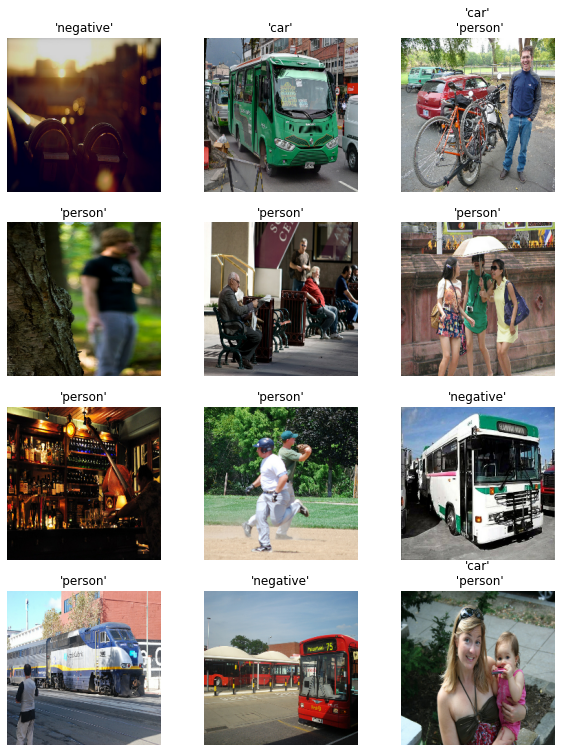

In [139]:
image_batch, label_batch = next(iter(val_ds))

plt.figure(figsize=(10, 13))
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    img = ((image_batch[i].numpy()+1)*127.5).astype("uint8") # channels = 3
    plt.imshow(img) # channels = 3
    #img = (tf.squeeze(image_batch[i]).numpy()) # channels = 1
    #plt.imshow(img, cmap='gray') # channels = 1
    label = label_batch[i]
    label_ixs = tf.where(label).numpy()
    plt.title(str(class_names[label_ixs]).replace("[", "").replace("]",""))
    plt.axis("off")
plt.show()

As we can see, some images have multiple classes, and some just correspond to the negative one. Let's proceed to the model selection step.

# The model

In [114]:
best_small_models = pd.read_csv("parsed_classification_models.csv")[:5]
best_small_models

,Unnamed: 0,Model,Number of parameters,FLOPS (millions),Top-1 Error,Top-5 Error,Year
0,60,EfficientNet-B0,"5,288,548",414.31,24.77,7.52,2019
1,34,NASNet-A 4@1056,"5,289,978",584.90,25.68,8.16,2017
2,33,MobileNet,"4,231,976",579.80,26.61,8.95,2017
3,46,MobileNetV2,"3,504,960",329.36,26.97,8.87,2018
4,43,ShuffleNetV2,"2,278,604",149.72,31.44,11.63,2018


In [249]:
IMG_SHAPE = IMG_SIZE + (3,)

In [251]:
feature_extractor = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                alpha=0.35,
                                                weights='imagenet',
                                                include_top=False)

2023424/2019640 [==============================] - 0s 0us/step


In [252]:
def small_summary(model, nlastlines=6):
    ls_summ = []
    def append_to_list(line):
        ls_summ.append(line)
    model.summary(print_fn=append_to_list)
    print("\n".join(ls_summ[:4]))
    print("...\n...")
    print("\n".join(ls_summ[-nlastlines:]))

In [253]:
small_summary(feature_extractor)

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
...
...
out_relu (ReLU)                 (None, 7, 7, 1280)   0           Conv_1_bn[0][0]                  
Total params: 410,208
Trainable params: 396,128
Non-trainable params: 14,080
__________________________________________________________________________________________________


In [254]:
feature_extractor.trainable = False

In [255]:
classification_head = keras.Sequential([
    keras.layers.InputLayer(feature_extractor.output.shape[1:]), # batch size doesn't have to be included
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256), # no activation, like in the paper
    keras.layers.Dropout(0.1),
    keras.layers.Dense(len(class_names), activation="sigmoid") # multi label classification
])

In [256]:
small_summary(classification_head)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
...
...
dense_13 (Dense)             (None, 3)                 771       
Total params: 328,707
Trainable params: 328,707
Non-trainable params: 0
_________________________________________________________________


In [257]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
features = feature_extractor(inputs, training=False) # training=False to prevent BatchNorm parameters to be altered
outputs = classification_head(features)
model = tf.keras.Model(inputs, outputs)

In [258]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [259]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_0.35_224 (Functi (None, 7, 7, 1280)        410208    
_________________________________________________________________
sequential_6 (Sequential)    (None, 3)                 328707    
Total params: 738,915
Trainable params: 328,707
Non-trainable params: 410,208
_________________________________________________________________


In [260]:
model.evaluate(val_ds)

77/77 [==============================] - 2s 26ms/step - loss: 0.7696 - accuracy: 0.3325 - auc_4: 0.5111


[0.7696349620819092, 0.332511305809021, 0.5111445784568787]

In [261]:
initial_epochs=10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
738/738 [==============================] - 23s 32ms/step - loss: 0.3428 - accuracy: 0.7905 - auc_4: 0.9180 - val_loss: 0.3270 - val_accuracy: 0.7883 - val_auc_4: 0.9257racy: 0.7864 - - ETA: 1s - l
Epoch 2/10
738/738 [==============================] - 23s 31ms/step - loss: 0.3000 - accuracy: 0.8145 - auc_4: 0.9376 - val_loss: 0.2667 - val_accuracy: 0.8266 - val_auc_4: 0.9511
Epoch 3/10
738/738 [==============================] - 23s 32ms/step - loss: 0.2898 - accuracy: 0.8230 - auc_4: 0.9420 - val_loss: 0.2624 - val_accuracy: 0.8319 - val_auc_4: 0.9531
Epoch 4/10
738/738 [==============================] - 23s 31ms/step - loss: 0.2837 - accuracy: 0.8261 - auc_4: 0.9444 - val_loss: 0.2937 - val_accuracy: 0.8138 - val_auc_4: 0.9419
Epoch 5/10
738/738 [==============================] - 22s 30ms/step - loss: 0.2788 - accuracy: 0.8296 - auc_4: 0.9464 - val_loss: 0.2861 - val_accuracy: 0.8171 - val_auc_4: 0.9437
Epoch 6/10
738/738 [==============================] - 23s 31ms/step - lo

In [262]:
len(feature_extractor.layers)

155

In [263]:
for layer in feature_extractor.layers[100:]:
    layer.trainable=True

In [264]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [265]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
738/738 [==============================] - 24s 33ms/step - loss: 0.2587 - accuracy: 0.8435 - auc_5: 0.9539 - val_loss: 0.2675 - val_accuracy: 0.8278 - val_auc_5: 0.9512
Epoch 11/20
738/738 [==============================] - 23s 31ms/step - loss: 0.2581 - accuracy: 0.8426 - auc_5: 0.9542 - val_loss: 0.2735 - val_accuracy: 0.8257 - val_auc_5: 0.9489
Epoch 12/20
738/738 [==============================] - 22s 30ms/step - loss: 0.2573 - accuracy: 0.8425 - auc_5: 0.9545 - val_loss: 0.2794 - val_accuracy: 0.8220 - val_auc_5: 0.9468
Epoch 13/20
738/738 [==============================] - 23s 30ms/step - loss: 0.2572 - accuracy: 0.8446 - auc_5: 0.9545 - val_loss: 0.2822 - val_accuracy: 0.8208 - val_auc_5: 0.9459
Epoch 14/20
738/738 [==============================] - 23s 31ms/step - loss: 0.2573 - accuracy: 0.8429 - auc_5: 0.9544 - val_loss: 0.2751 - val_accuracy: 0.8245 - val_auc_5: 0.9484
Epoch 15/20
738/738 [==============================] - 23s 31ms/step - loss: 0.2571 - accuracy:

In [266]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Kique\AppData\Local\Temp\tmpeh7mfyqv\assets


INFO:tensorflow:Assets written to: C:\Users\Kique\AppData\Local\Temp\tmpeh7mfyqv\assets


In [267]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [268]:
sys.getsizeof(tflite_model)

1499825

# References

- [Coco dataset](https://cocodataset.org/#home)
- [CocoAPI for Python3 and Windows](https://github.com/philferriere/cocoapi#egg=pycocotools^&subdirectory=PythonAPI)
- [Visual wake word dataset](https://arxiv.org/abs/1906.05721)
- [Python docs](https://docs.python.org/3/)
- A lot of [stackoverflow](https://stackoverflow.com/)
- [The Unknown Benefits of using a Soft-F1 Loss in Classification Systems](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d)
- [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [Classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
- [Handling Data Imbalance in Multi-label Classification (MLSMOTE)](https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87)
- [Tensorflow guides](https://www.tensorflow.org/guide) and [tensorflow tutorials](https://www.tensorflow.org/tutorials)

